In [1]:
import sys
sys.path.append('../')
from Utils import *
from einops import rearrange
import matplotlib.pyplot as plt

In [27]:
# Read one subject/case from a directory containing the corresponding .mat files
data_dir = '/mnt/nas/nas3/openData/rawdata/4dFlow/ChallengeData/Demo/TaskR1R2/TrainSet/Aorta/Center012/Philips_30T_Ingenia/P005/'

# `load_mat` takes the .mat file path and variable name (`key`) as input.
# It returns a lazy HDF5-like handle (h5py-style): data is not loaded into memory
# until you index it.
# load a pre-reconstructed image (assumed to be already reconstructed)
kdata_full = load_mat(data_dir + '/kdata_full.mat', key='kdata_full')
coilmap    = load_mat(data_dir + '/coilmap.mat',    key='coilmap')
segmask    = load_mat(data_dir + '/segmask.mat',    key='segmask')
params     = read_params_csv(data_dir + '/params.csv')

# Load COO representation and reconstruct dense array from compressed .npz file
img_csllr = load_coo_npz(f"{data_dir}/img_ktGaussian10_CS.npz", as_dense=True)

# Use [()] to materialize the entire dataset into RAM as a NumPy array.
kdata_full = kdata_full[()]
coilmap    = coilmap[()]
segmask    = segmask[()]
img_csllr = img_csllr[()]

img = np.sum(k2i_numpy(kdata_full, ax=[-1, -2, -3]) * np.conj(coilmap), axis=-4)
Nv, Nt, SPE, PE, FE = img.shape

VENC = params['VENC']
VOrder = params['venc_order']

Due to system imperfections (notably gradient field nonlinearity), voxels farther from the FOV center can exhibit a spatially dependent, often time-stable background phase offset. A compact model is:

$$
img_v(\mathbf{r}) = M_v(\mathbf{r}) \exp\left(i\left[\theta_0(\mathbf{r}) + \theta_v(\mathbf{r}) + \Delta\theta^{bg}(\mathbf{r})\right]\right)
$$

where $\Delta\theta^{bg}(\mathbf{r})$ is the position-dependent phase offset; in post-processing it is commonly removed by fitting a smooth model and canceling it in the complex domain.

In [28]:
# We artificially applied a linearly increasing background phase offset (up to max_phase) to img and img_csllr. 
# In practice, such phase offsets are often less noticeable at higher VENC
# here we simulate an exaggerated, clearly visible phase offset solely for demonstration/visualization purposes.
max_phase = 0.8
x = np.linspace(-1, 1.0, FE, dtype=np.float32) 
phase = (max_phase * x)[None, None, :]        
phase = np.broadcast_to(phase, (SPE, PE, 92)).copy()  
img[1:] *= np.exp(1j * phase)[None, None, :, :, :]
img_csllr[1:] *= np.exp(1j * phase)[None, None, :, :, :]

# Estimate the background-phase correction maps from the ground-truth image `img`.
corr_maps = execute_MSAC(img, corr_fit_order=3, th=0.1)
img_corr = img.copy()
img_corr[1:] *= np.exp(-1j * corr_maps)

# Apply the estimated correction to the reconstructed complex image `img_csllr`
# by canceling the background phase in the complex domain.
img_csllr_corr = img_csllr.copy()
img_csllr_corr[1:] *= np.exp(-1j * corr_maps)

mag, flow = complex2magflow(img)
mag_corr, flow_corr = complex2magflow(img_corr)

mag_csllr, flow_csllr = complex2magflow(img_csllr)
mag_csllr_corr, flow_csllr_corr = complex2magflow(img_csllr_corr)

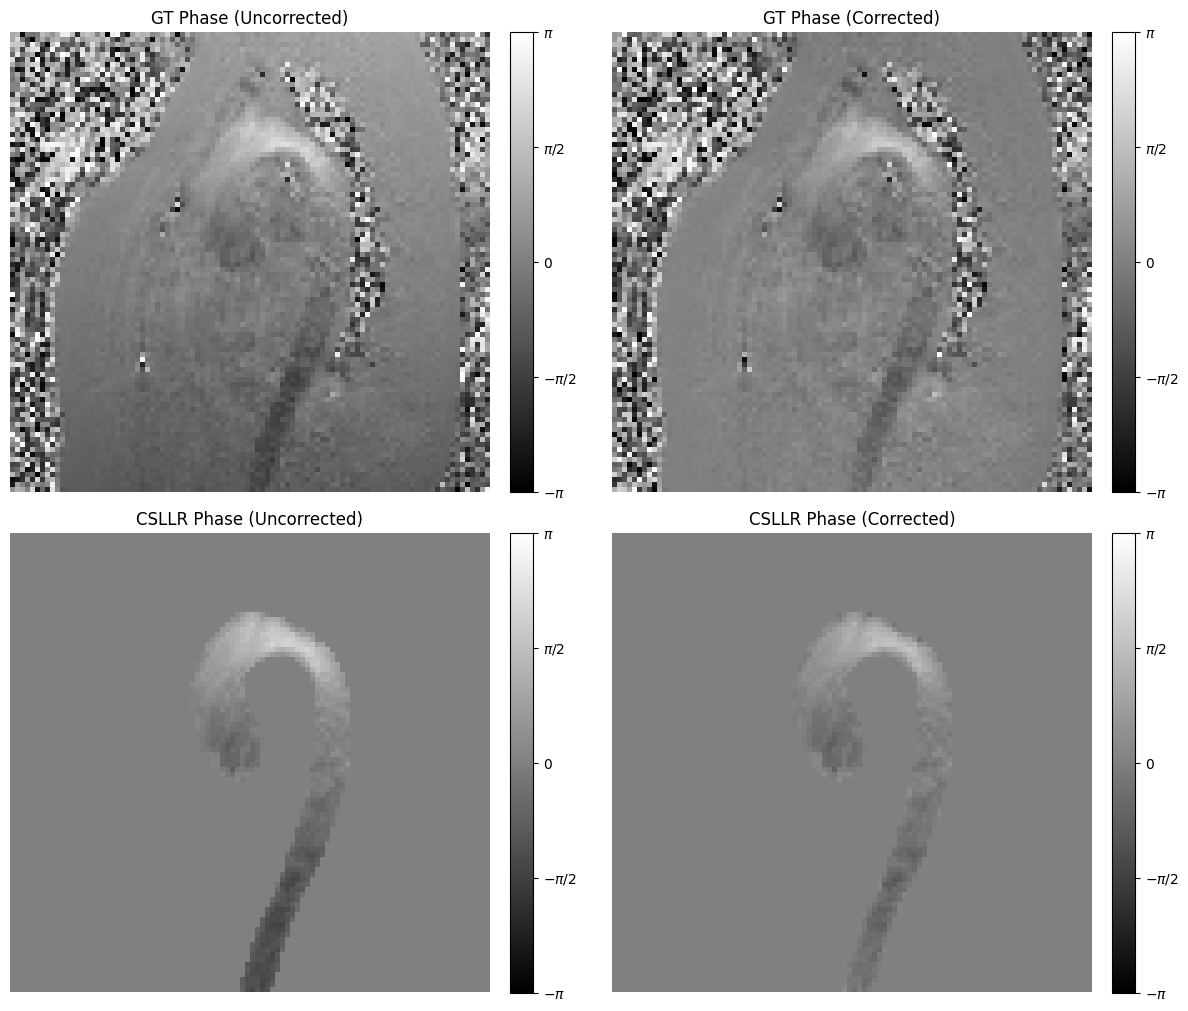

In [30]:
v = 1
t = 2
s = 8

sl_phase_img        = flow[v, t, s, :, :].T
sl_phase_img_corr   = flow_corr[v, t, s, :, :].T
sl_phase_csllr      = flow_csllr[v, t, s, :, :].T
sl_phase_csllr_corr = flow_csllr_corr[v, t, s, :, :].T

phase_vmin, phase_vmax = -np.pi, np.pi 
ticks  = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
labels = [r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"]

fig, ax = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)

im00 = ax[0, 0].imshow(sl_phase_img, cmap="gray", origin="lower", vmin=phase_vmin, vmax=phase_vmax)
ax[0, 0].set_title("GT Phase (Uncorrected)")
ax[0, 0].axis("off")
cb00 = fig.colorbar(im00, ax=ax[0, 0], fraction=0.046, pad=0.04)
cb00.set_ticks(ticks)
cb00.set_ticklabels(labels)

im01 = ax[0, 1].imshow(sl_phase_img_corr, cmap="gray", origin="lower", vmin=phase_vmin, vmax=phase_vmax)
ax[0, 1].set_title("GT Phase (Corrected)")
ax[0, 1].axis("off")
cb01 = fig.colorbar(im01, ax=ax[0, 1], fraction=0.046, pad=0.04)
cb01.set_ticks(ticks)
cb01.set_ticklabels(labels)

im10 = ax[1, 0].imshow(sl_phase_csllr, cmap="gray", origin="lower", vmin=phase_vmin, vmax=phase_vmax)
ax[1, 0].set_title("CSLLR Phase (Uncorrected)")
ax[1, 0].axis("off")
cb10 = fig.colorbar(im10, ax=ax[1, 0], fraction=0.046, pad=0.04)
cb10.set_ticks(ticks)
cb10.set_ticklabels(labels)

im11 = ax[1, 1].imshow(sl_phase_csllr_corr, cmap="gray", origin="lower", vmin=phase_vmin, vmax=phase_vmax)
ax[1, 1].set_title("CSLLR Phase (Corrected)")
ax[1, 1].axis("off")
cb11 = fig.colorbar(im11, ax=ax[1, 1], fraction=0.046, pad=0.04)
cb11.set_ticks(ticks)
cb11.set_ticklabels(labels)

plt.show()